**Import Library**

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import math

from IPython.display import Image
from datetime import timedelta
from scipy import optimize
from scipy import stats
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
from datetime import timedelta, datetime

%matplotlib inline

In [2]:
#from google.colab import drive
#drive.mount("/content/drive")

#jika dari dataset github
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/USGS/eq_1970_M6.csv"
#dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/SCEDC/SouthCalifornia-1982-2011_Physics-of-Data.dat.txt"
#data = np.genfromtxt(dataset)
df = pd.read_csv(dataset)
#df = pd.DataFrame(data, columns=['index', 'trigger', 'time', 'magnitude', 'X', 'Y', 'Z'])
#df = df.sort_values(by=['time'])


In [9]:
df = df

# Konversi kolom 'time' ke format datetime
df['time'] = pd.to_datetime(df['time'])

# Seleksi data hanya untuk tahun 1968 - 2018
df_selected = df[(df['time'].dt.year >= 1968) & (df['time'].dt.year <= 2018)]

# Buat kolom baru 'date' yang berisi bagian tanggal dari kolom 'time'
df_selected['date'] = df_selected['time'].dt.strftime('%Y-%m-%d')

# Ambil bagian jam, menit, dan detik dari kolom 'time'
df_selected['time'] = df_selected['time'].dt.strftime('%H:%M:%S')

# Pilih kolom yang akan digunakan
df_selected = df_selected[['time', 'date', 'latitude', 'longitude','magType' ,'mag','depth', 'place']]

# Tampilkan lima baris pertama dari data terpilih
df_selected.head(5)


,time,date,latitude,longitude,magType,mag,depth,place
0,16:47:58,2017-12-15,-7.4921,108.1743,mww,6.5,90.0,"1km E of Kampungbaru, Indonesia"
1,18:03:43,2017-12-13,-54.2189,2.1628,mww,6.5,17.0,"80km WNW of Bouvet Island, Bouvet Island"
2,21:41:31,2017-12-12,30.8275,57.2982,mww,6.0,8.0,"63km NNE of Kerman, Iran"
3,08:43:18,2017-12-12,30.7372,57.2795,mww,6.0,12.0,"53km NNE of Kerman, Iran"
4,15:14:24,2017-12-09,10.0928,140.2016,mww,6.1,10.0,"50km NW of Fais, Micronesia"


In [10]:
# transformation from Cartesian to spherical coordinates
#R = 6371500 # Earth's radius
#df["longitude"] = np.arctan2(df["Y"],df["X"])*180/np.pi
#df["latitude"] = np.arcsin(df["Z"]/np.sqrt(df["X"]**2+df["Y"]**2+df["Z"]**2))*180/np.pi
#df["depth"] = np.sqrt(df["X"]**2+df["Y"]**2+df["Z"]**2) - R

# convert time from seconds to years
#df['date'] = pd.to_datetime(df['time'], unit='s', origin='01/01/1982')

#df.head(10)

print('Total Jumlah Kejadian Gempa:',df.shape[0])

Total Jumlah Kejadian Gempa: 5328


In [4]:
# daftar jenis magnitude
df['magType'].value_counts()

magType
mw     2128
mwc    1602
mww     957
mwb     919
ms      708
mb      379
ml       14
mh        3
mwr       2
md        2
Name: count, dtype: int64

In [5]:
mag_keep = np.asarray(df['magType'].value_counts().head(6).index)
mag_keep = mag_keep.astype(str)

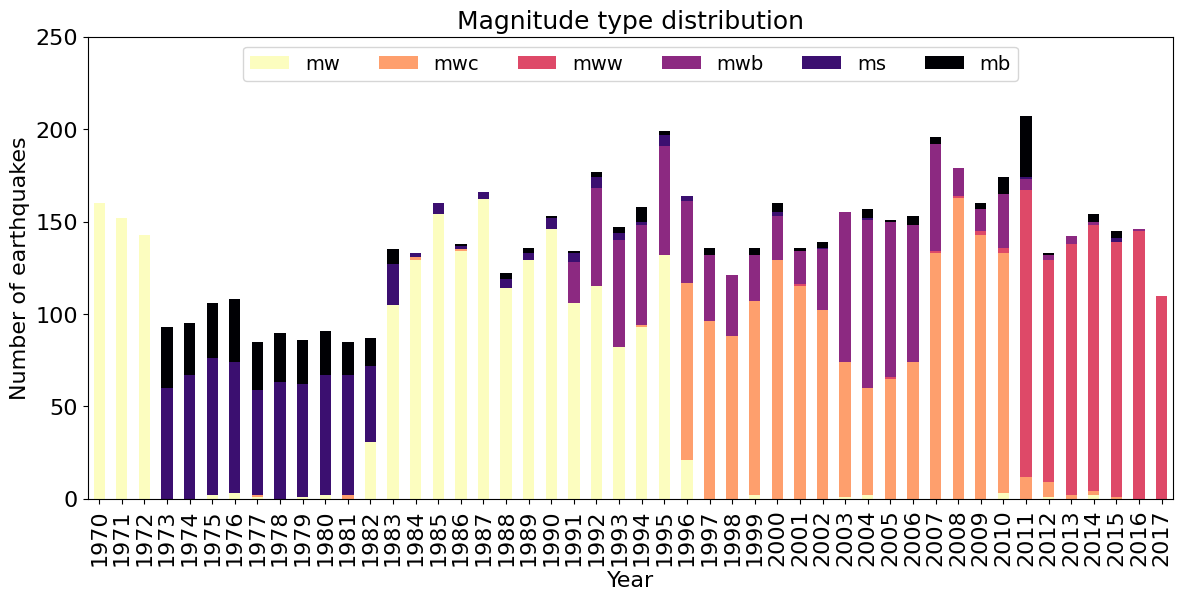

In [6]:
# Settings for all figures
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 14

df['dt_time'] = df['time'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add an additional column for the year
df['year'] = df['dt_time'].apply(lambda x: x.year)

# Groupby year
df_cut = df[['year', 'magType']]
df_magType = df_cut.groupby('year')['magType'].value_counts().unstack()

# Keep only the top 6 magnitude types for plotting
df_magType = df_magType[mag_keep]

# Plot the dataFrame as a stacked bar chart
ax = df_magType.plot(kind='bar', stacked=True,
                     colormap='magma_r', figsize=(14,6))
ax.set_ylim([0, 250])
ax.legend(loc='upper center', ncol=6)
plt.xlabel('Year'), plt.ylabel('Number of earthquakes')
plt.title('Magnitude type distribution')
plt.show()

In [7]:
# Cut out years 1970 - 1982
df = df[df.year > 1982]

# Print the minimum year in the column
print("Earliest year of data:",min(df['year']))

# Total number of earthquakes
N_tot = df['mag'].count()
print('Total Jumlah EQ:', N_tot)

Earliest year of data: 1983
Total Jumlah EQ: 5328


**Gutenberg–Richter law**

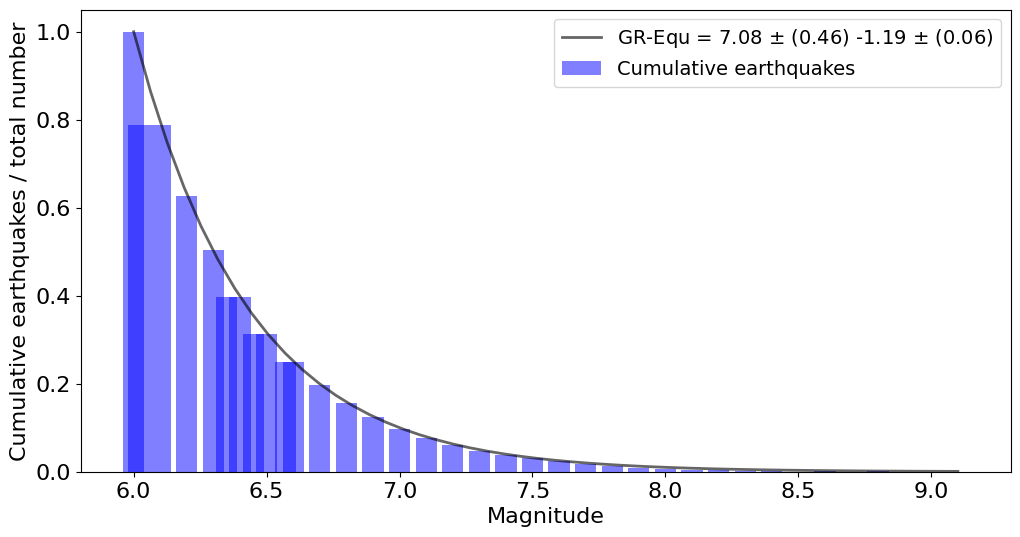

In [8]:
# Number of earthquakes by magnitude
mag_tot = df['mag'].value_counts()
mag_tot.sort_index(axis=0, inplace=True)

# Convert the indices of the Series to an np.ndarray
mags = np.asarray(mag_tot.index)

# between 6.0 and 9.1 (step=0.1)
mags_all = np.linspace(6.0,9.1,num=32)


magnitudes = np.arange(6,9,0.5)
counts = np.zeros(magnitudes.shape[0])

# compute the number of events with magnitude M >= m
i = 0
for m in magnitudes:
    counts[i] = df[df['mag'] >= m]['mag'].count()
    i += 1

# normalize
norm = np.sum(counts)
counts_n = counts/norm

# filter by removing empty data
counts_n_f = counts_n[counts_n!=0]
magnitudes_f = magnitudes[counts_n!=0]

# Add values for missing magnitudes
#mag_add = pd.Series(data=np.zeros(len(mags_miss)), index = mags_miss)
#mag_tot = pd.concat([mag_tot, mag_add])
mag_tot = pd.concat([mag_tot])
mag_tot.sort_index(axis=0, inplace=True)

mag_Ntot = np.cumsum(mag_tot.values[::-1])[::-1]

# Plot Gutenberg-Richter relationship: N = 10**(a-bM)
a = np.log10(1)+6
M = np.linspace(6, 9.1)
N = np.power(10, (a-M))

# compute linear regression
reg = stats.linregress(magnitudes_f, np.log10(counts_n_f))


label = r'GR-Equ = {:.2f} $\pm$ ({:.2f})'.format(reg.intercept, reg.intercept_stderr) + r' {:.2f} $\pm$ ({:.2f})'.format(reg.slope, reg.stderr)

plt.figure(figsize=(12,6))
ax1 = plt.bar(mag_tot.index, mag_Ntot/N_tot,
              width=0.08, color='blue', alpha=0.5,
              label='Cumulative earthquakes')
ax2 = plt.plot(M, N, 'k', linewidth = 2, alpha=0.6,
         label=label)

plt.ylabel('Cumulative earthquakes / total number')
plt.xlabel('Magnitude')
plt.legend()
plt.show()